In [1]:
import cv2
import numpy as np
import os


# THIS MIGHT BE NEEDED IF DATABASES ALREADY HAVE THEIR LR IMAGES

def create_lr_image(hr_image_path, lr_image_path, downscale_factor, if_save=True):
    # Read HR image
    hr_image = cv2.imread(hr_image_path)
    # Gaussian Blur
    # blurred = cv2.GaussianBlur(hr_image, (0, 0), sigmaX=downscale_factor, sigmaY=downscale_factor)
    
    # Downsampling
    width = int(hr_image.shape[1] / downscale_factor)
    height = int(hr_image.shape[0] / downscale_factor)
    lr_image = cv2.resize(hr_image, (width, height), interpolation=cv2.INTER_LINEAR)
    
    if if_save:
        cv2.imwrite(lr_image_path, lr_image)
    return lr_image


# def process_all_images(hr_dir, lr_dir_suffix='LR', downscale_factor=4):
#     # Create the directory for low-resolution images if it does not exist
#     lr_dir = os.path.join(hr_dir, lr_dir_suffix)
#     if not os.path.exists(lr_dir):
#         os.makedirs(lr_dir)
    
#     # Process each image in the high-resolution directory
#     for hr_image_name in os.listdir(hr_dir):
#         if hr_image_name.endswith('.png'):  # assuming the images are in PNG format
#             hr_image_path = os.path.join(hr_dir, hr_image_name)
#             lr_image_path = os.path.join(lr_dir, hr_image_name)
#             create_lr_image(hr_image_path, lr_image_path, downscale_factor)

# # Example usage
# process_all_images('HR', 'LRx3', 3)




In [2]:
import cv2
import numpy as np
# from skimage.metrics import structural_similarity
from skimage.metrics import structural_similarity as compare_ssim
# import cv2



#Manual SSIM calculation
def ssim(img1, img2):
    """SSIM values range between -1 and 1, where 1 indicates perfect similarity. Close to 1 is good (little perceptual difference)
    SSIM = 0 suggest no correlation between the strucutral information i nthe two images (rare case). 
    SSIM < 0 suggest that the images are very different. They have structural changes (inverted colors or 
    other significant transformations)."""
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    def compute_ssim(img1, img2):
        mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # Valid region
        mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
        mu1_sq = mu1**2
        mu2_sq = mu2**2
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
        sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
        sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
        
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        return ssim_map.mean()

    # Convert the images to float64 and separate the channels
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    ssim_scores = []
    for i in range(3):  # Assuming img1 and img2 are RGB images
        ssim_scores.append(compute_ssim(img1[:,:,i], img2[:,:,i]))

    return np.mean(ssim_scores)

# Example usage
# img1 = cv2.imread('path_to_hr_image.jpg', cv2.IMREAD_COLOR)
# img2 = cv2.imread('path_to_sr_image.jpg', cv2.IMREAD_COLOR)
# print("SSIM:", ssim(img1, img2))


# SSIM using skimage.metrics
def compute_ssim(img1, img2):
    # Assume img1 and img2 are already loaded and are in BGR format as loaded by OpenCV
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Compute SSIM between two images
    ssim_value, _ = compare_ssim(img1_gray, img2_gray, full=True)
    return ssim_value




LR Image shape: (90, 62, 3)
HR Image shape: (361, 250, 3)
SR Image shape: (361, 250, 3)
PSNR value: 29.36136232208196
SSIM value: 0.5753200884168964
SSIM value using skimage.metrics: 0.613998489620107


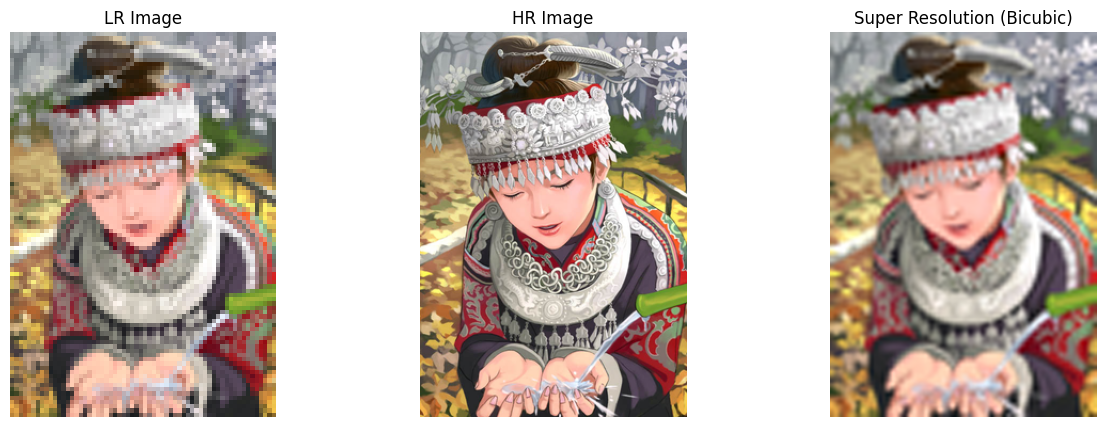

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def bicubic_super_resolution(lr_image_path, target_dimensions):
    # LR image
    lr_image = cv2.imread(lr_image_path, cv2.IMREAD_COLOR)
    # Basic bicubic interpolation
    sr_image = cv2.resize(lr_image, target_dimensions, interpolation=cv2.INTER_CUBIC)
    return sr_image


# From Paper, PSNR calculation
# def calc_psnr(img1, img2):
#     return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


def calculate_psnr(hr_image, sr_image):
    # Ensure the images are of the same dimension
    if hr_image.shape != sr_image.shape:
        raise ValueError("HR and SR images must have the same dimensions for PSNR calculation.")

    # Mean Squared Error (MSE) between the HR and SR images
    mse = np.mean((hr_image - sr_image) ** 2)
    
    if mse == 0:
        return float('inf')  # Infinite PSNR means no error
    else:
        # PSNR
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr

# Example usage
# hr_image_path = 'path_to_high_res_image.jpg'
# lr_image_path = 'path_to_low_res_image.jpg'
lr_image_path = 'Datasets/Set14/Set14_LR_x4/comic.png'
hr_image_path = 'Datasets/Set14/Set14_HR/comic.png'
hr_image = cv2.imread(hr_image_path, cv2.IMREAD_COLOR)  # Read HR image to get dimensions

# Generate the super-resolved image using the dimensions of the HR image
lr_image = cv2.imread(lr_image_path, cv2.IMREAD_COLOR)
sr_image = bicubic_super_resolution(lr_image_path, (hr_image.shape[1], hr_image.shape[0]))

# Calculate PSNR
psnr_value = calculate_psnr(hr_image, sr_image)

im_to_plot = [lr_image, hr_image, sr_image]

#Printing LR, HR, and SR image shapes.
print(f'LR Image shape: {lr_image.shape}')
print(f'HR Image shape: {hr_image.shape}')
print(f'SR Image shape: {sr_image.shape}')



plt.figure(figsize=(15, 5))

for count,im in enumerate(im_to_plot):
    # convert bgr to rgb 
    
    plt.subplot(1,3,count+1)
    if count ==0:
        plt.title('LR Image')   
    elif count ==1:
        plt.title('HR Image')
    else:
        plt.title('Super Resolution (Bicubic)')
    plt.axis('off')
    
    rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb, cmap = plt.cm.Spectral)



print("PSNR value:", psnr_value)

print("SSIM value:", ssim(hr_image, sr_image))
print("SSIM value using skimage.metrics:", compute_ssim(hr_image, sr_image))


In [ ]:
# python test.py --weights-file pretrained/srcnn_x4.pth --image-file ../../Datasets/Set14/Set14_LR_x4/comic.png --scale 4

In [17]:
import sys

In [22]:
from models import SRCNN

ModuleNotFoundError: No module named 'models'

In [25]:
pwd()

'/Users/j/Documents/GitHub/CV_VideoSR_designproject_2024'

In [ ]:
model = SRCNN-pytorch/
model.load_state_dict(torch.load("pretrained/srcnn_x4.pth"))